## Simple Density Estimation

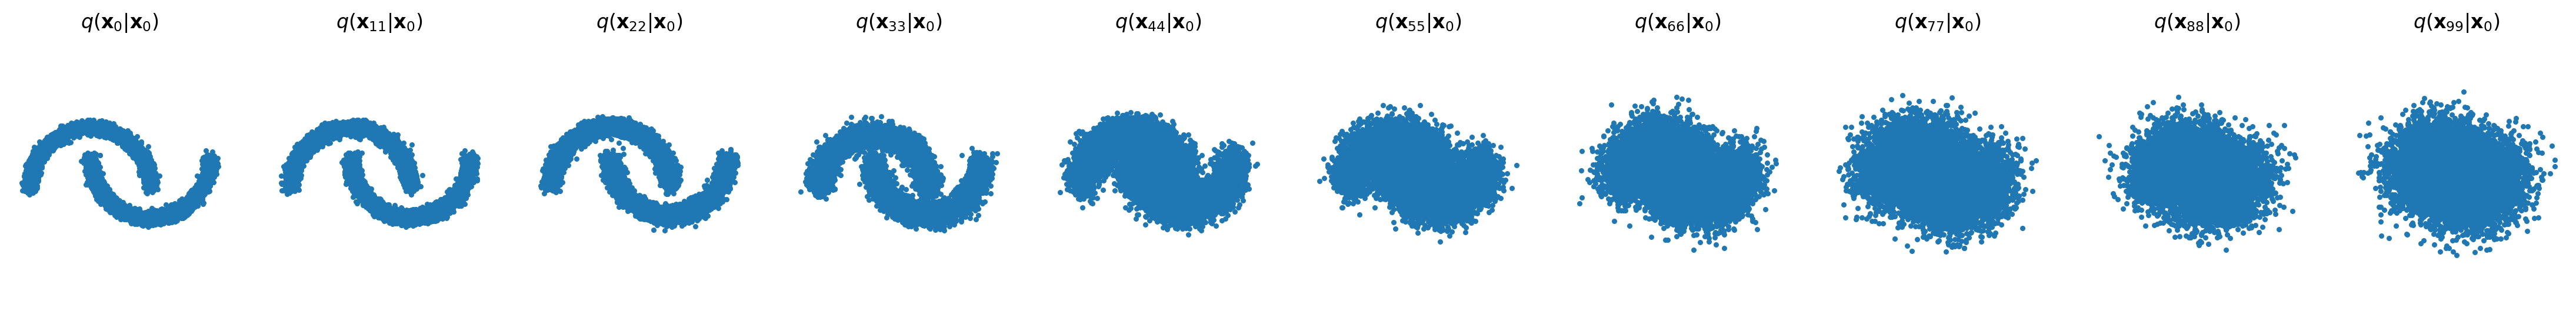

In [8]:
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_moons

from stellarperceptron.ddpm import ConditionalDiffusionModel

device = "cuda:1"
nn_model = ConditionalDiffusionModel(
    dim=2, cond_dim=0, dense_num=128, num_steps=100, beta_end=1.0e-2, device=device
)
moons, _ = make_moons(10**4, noise=0.05)
dataset = torch.tensor(moons, dtype=torch.float32, device=device)

fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = nn_model.q_x(dataset, torch.tensor([i * 10], device=device)).cpu()
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=5)
    axs[i].set_axis_off()
    axs[i].axis("equal")
    axs[i].set_title("$q(\\mathbf{x}_{" + str(i * 11) + "}|\\mathbf{x}_0)$")

tensor(0.3952, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.3499, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.5557, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.6832, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.3871, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.6192, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.3987, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.5705, device='cuda:1', grad_fn=<MseLossBackward0>)


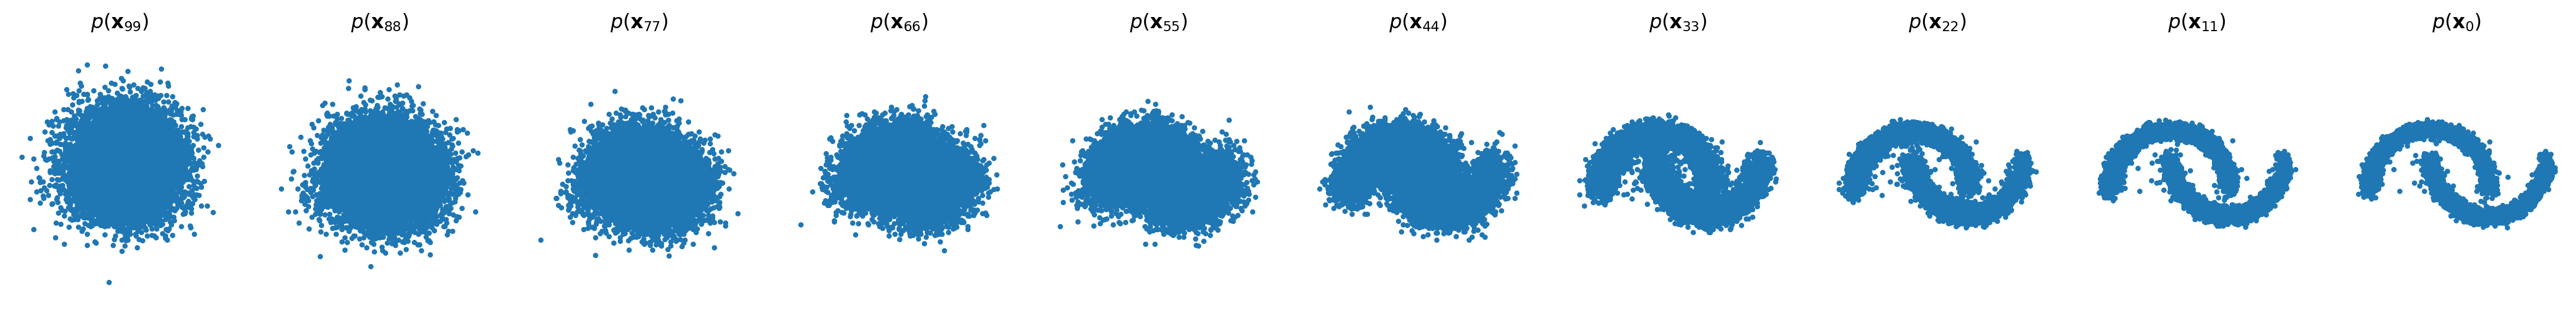

In [10]:
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
batch_size = 128

for t in range(256):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i : i + batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = nn_model.noise_estimation_loss(batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Calling the step function to update the parameters
        optimizer.step()
        # Print loss
    if t % 32 == 0:
        print(loss)
with torch.inference_mode():
    x_seq = nn_model.p_sample_loop(size=len(dataset), return_steps=True).cpu()
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(0, 10):
    cur_x = x_seq[i * 11]
    axs[i].scatter(cur_x[:, 0], cur_x[:, 1], s=5)
    axs[i].set_axis_off()
    axs[i].axis("equal")
    axs[i].set_title(
        f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[i*11].cpu()[0])}}})$"
    )